## One lane simulation

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
class TrafficSimulation:

    def __init__(self, road_length=100, car_density=0.2, prob_slow=0.5,
                 max_speed=5):
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        # Choose random locations to place cars
        random_indexes = np.random.choice(
            range(self.road_length),
            size=int(round(car_density * self.road_length)),
            replace=False)
        # Give each car a random initial speed from 0 to max_speed
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []

    def update(self, optimized=True):
        '''
        Advance one time step in the simulation.
        '''
        if optimized:
            return self.update_optimized()
        
        # Update car speeds
        for i in range(self.road_length):
            if self.state[i] != -1:
                distance = 1  # The number of empty cells between this car and the next plus 1
                while self.state[(i + distance) % self.road_length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (self.state[i] > 0) and (np.random.uniform() < self.prob_slow):
                    self.state[i] -= 1

        # Move cars forward using their new speeds
        new_state = -np.ones(self.road_length, dtype=int)
        for i in range(self.road_length):
            if self.state[i] != -1:
                new_state[(i + self.state[i]) % self.road_length] = self.state[i]
        self.state = new_state

        # Update traffic flow history
        self.average_traffic_flow.append(sum(self.state[self.state > 0]) / self.road_length)
        self.time_step += 1

    def update_optimized(self):
        '''
        Advance one time step in the simulation.
        '''
        # Get the location of each car
        car_indexes = np.where(self.state >= 0)[0]
        
        # If there are no cars, we have nothing to update
        if len(car_indexes) == 0:
            self.average_traffic_flow.append(0)
            self.time_step += 1
            return

        # Get the speed of each cars
        car_speeds = self.state[car_indexes]
        # Get the distance from each car to the next car
        car_distances = np.ediff1d(
            np.concatenate((car_indexes,
                            [car_indexes[0] + self.road_length])))
        # Update car speeds
        # Acceleration
        car_speeds = np.where(
            car_speeds + 1 <= self.max_speed,
            car_speeds + 1,
            self.max_speed)
        # Deceleration
        car_speeds = np.where(
            car_speeds >= car_distances,
            car_distances - 1,
            car_speeds)
        # Randomization
        moving_car_indexes = np.where(car_speeds > 0)[0]
        car_speeds[moving_car_indexes] -= (np.random.uniform(size=len(moving_car_indexes)) < self.prob_slow)

        # Move cars forward using their new speeds
        car_indexes += car_speeds
        car_indexes %= self.road_length
        self.state.fill(-1)
        self.state[car_indexes] = car_speeds

        # Update traffic flow history
        self.average_traffic_flow.append(sum(car_speeds) / self.road_length)
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [9]:
sim2 = TrafficSimulation(road_length = 100, car_density = 0.1, max_speed = 5, prob_slow = 0.5)
for i in range(22):
    sim2.display()
    sim2.update()

.......31...1........3.............3..0..................................1..3............1..0.......
.......0..2...2.........3...........1.0...................................1....3...........20.......
........1....3..2..........3.........1.1....................................2.....3........0.1......
.........1....1....3..........3.......1.1.....................................2......3......1.1.....
...........2....2......4..........4....1..2.....................................2.......3...0..1....
..............3....3.......4.........3..1....3....................................2........3.1...2..
..................4....4........5......2..2......4..................................2......0...2...2
..3..................3......5........5..1....3........5...............................2.....1.....3.
.3...3..................3........5....1..1.......4........4.............................2.....2.....
....3...3..................3........3..1...2.........4........4...........................2

In [10]:
#function to get flow from simulation
def get_q(p = 0.1, n_sims = 20, timesteps = 200, t_0 = 100, display = False, p_slow=0.5):
    sim = TrafficSimulation(road_length=200, car_density = p, max_speed = 5, prob_slow = p_slow)
    flows = []
    for i in range(n_sims):
        #simulate without collecting data for the first t_0 timesteps
        for _ in range(t_0 + timesteps):
            sim.update()
        flows.append(np.mean(sim.average_traffic_flow[-timesteps:]))
    return sum(flows)/n_sims  

In [11]:
results = {}
N = 201

for p_slow in [0, 0.1, 0.25, 0.3333, 0.5]:
    
    density = np.linspace(0, 1, N)
    flows = []
    
    for n_sims in [1, 20]:
        flows.append(np.zeros(N))
        for i in range(N):
            flows[-1][i] = get_q(p=density[i], n_sims=n_sims, timesteps=100, p_slow=p_slow)
    
    results[p_slow] = [density] + flows

In [12]:
def make_plots(t, flow, flow2, p_slow, power):
    max_speed = 5
    t = t[1:-1]
    flow = flow[1:-1]
    flow2 = flow2[1:-1]
    plt.figure(figsize=(6,6))
    plt.title(f'Average traffic flow for p_slow={p_slow}')
    plt.scatter(t, flow, color ="black", s=3)
    plt.plot(t, flow2, color ="black", label = "Simulation results")

    plt.plot(t, (max_speed - p_slow) * t, 'b:')
    plt.axvline((1 - p_slow)/(max_speed + 1), linestyle=':', color='b')
    plt.plot(t, (1 - p_slow ** power) * (1 - t), 'r:')

    plt.ylabel('flow [cars per time step]',labelpad=10)
    plt.xlabel('density [cars per site]',labelpad=10)
    plt.tick_params(labelsize=12)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.show()

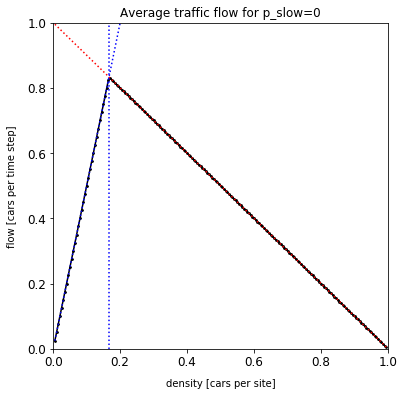

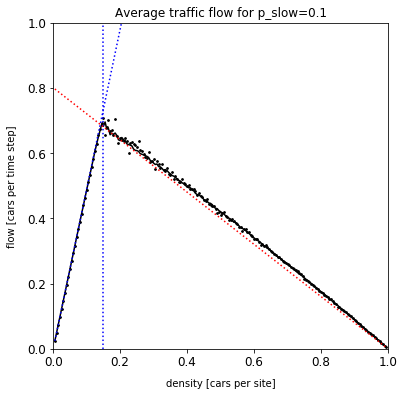

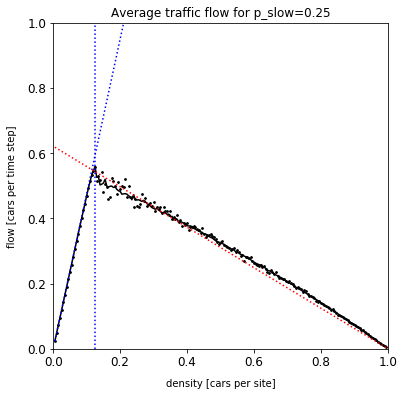

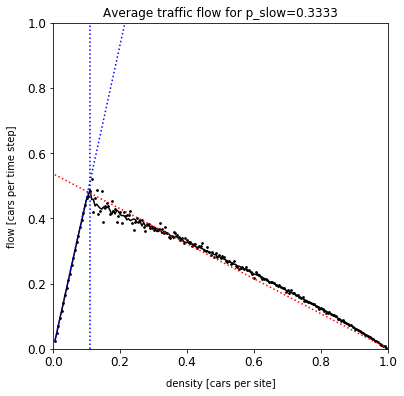

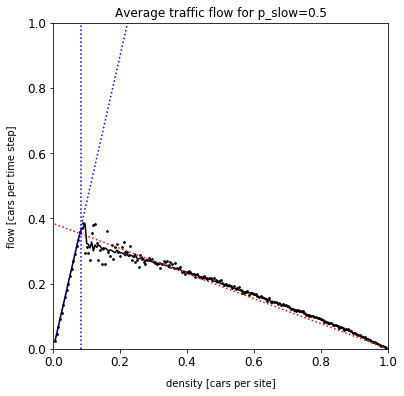

In [13]:
for p, (t, flow, flow2) in results.items():
    make_plots(t, flow, flow2, p, power=0.7)

In [14]:
def mfa_original(v, density, p_slow):
    '''
    Calculated update distribution over speeds given the current distribution by applying the MFA traffic rules.
    
    v: car speed probability vector. v[i] is the probability that a car is moving at speed i.
    density: the average car density
    p_slow: probability of random slow-down
    
    Returns: new updated car speed probability vector
    '''
    v_max = len(v) - 1
    new_v = [0] * len(v)
    for v_from in range(v_max + 1):
        speed = v_from  # Current speed, will be updated below
        # Accelerate
        if speed < v_max:
            speed += 1
        # Brake when there is a car in front
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = (1-density)**(distance-1) * density
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance
        # No cars in front up to distance == speed
        new_v[speed] += v[v_from] * (1-density)**speed * (1-p_slow)
        new_v[speed-1] += v[v_from] * (1-density)**speed * p_slow
    return new_v

In [15]:
def mfa_new(v, density, p_slow):
    '''
    Calculated update distribution over speeds given the current distribution by applying the MFA traffic rules.
    
    v: car speed probability vector. v[i] is the probability that a car is moving at speed i.
    density: the average car density
    p_slow: probability of random slow-down
    
    Returns: new updated car speed probability vector
    '''
    
    def prod(iterable):
        from functools import reduce
        from operator import mul
        return reduce(mul, iterable, 1)
    
    v_max = len(v) - 1
    new_v = [0] * len(v)
    
    if density <= (1 - p_slow) / (max_speed + 1):
        # At very low densities, we have free-flowing traffic
        if density > 0:
            expected_gap = min(v_max, 1 / density - 1)*(1-p_slow)+min(v_max-1, 1 / density - 2)*p_slow
        else:
            expected_gap = v_max
        car_probabilities = [0] + [0] * int(expected_gap)
        car_probabilities.append(1 - expected_gap % 1)
    else:
        expected_gap = min(v_max, 1 / density - 1)
        car_probabilities = [0] + [0] * int(expected_gap)
        car_probabilities.append(1 - (expected_gap % 1) * (1 - p_slow/2))
    car_probabilities = car_probabilities[:v_max+1]
    car_probabilities.extend([1] * (v_max + 1 - len(car_probabilities)))

    for v_from in range(v_max + 1):
        speed = v_from  # Current speed, will be updated below
        # Accelerate
        if speed < v_max:
            speed += 1
        
        # Brake when there is a car in front
        for distance in range(1, speed + 1):
            # Probability that a car is in front at a particular distance
            car_at_distance = prod(1 - c for c in car_probabilities[1:distance]) * car_probabilities[distance]
            if distance > 1:
                new_v[distance-1] += v[v_from] * car_at_distance * (1-p_slow)
                new_v[distance-2] += v[v_from] * car_at_distance * p_slow
            else:
                new_v[distance-1] += v[v_from] * car_at_distance

        # No cars in front up to distance == speed
        no_cars = prod(1 - c for c in car_probabilities[1:speed+1])
        new_v[speed] += v[v_from] * no_cars * (1-p_slow)
        new_v[speed-1] += v[v_from] * no_cars * p_slow
    return new_v

In [16]:
def average_speed(v):
    return np.sum(np.array(v) * np.arange(len(v)))

def average_flow(v, density):
    return density * average_speed(v)

In [17]:
def compute_mfa(mfa, densities, max_speed=5, p_slow=0.5):
    flows = []
    for density in densities:
        v = [1/(max_speed+1)] * (max_speed + 1)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check before
        for i in range(100):
            v = mfa(v, density, p_slow)
        assert abs(sum(v) - 1) < 1e-6  # Sanity check after
        flows.append(average_flow(v, density))
        #flows.append(average_speed(v))
    return np.array(flows)

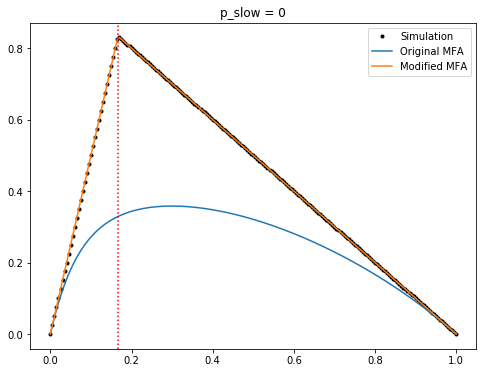

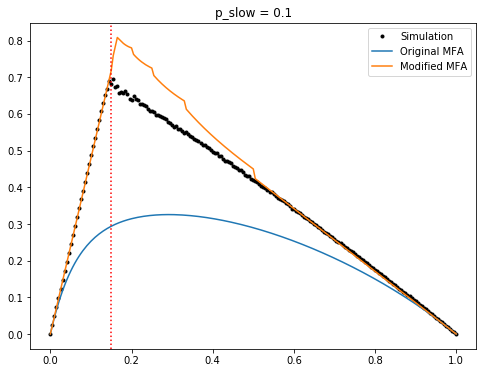

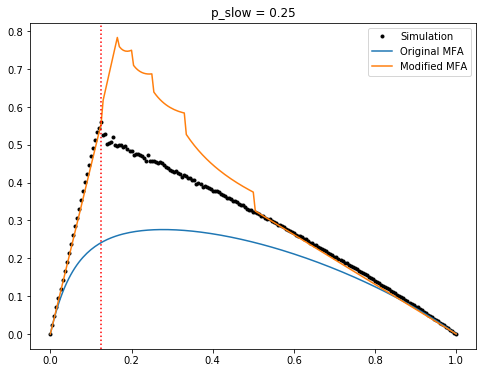

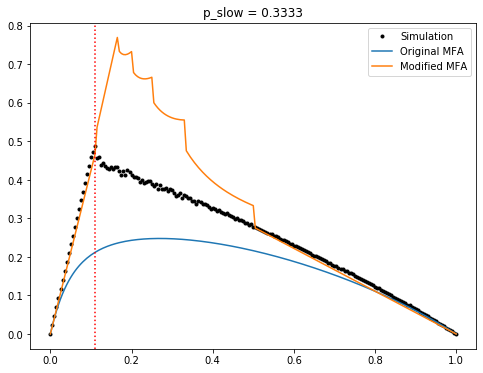

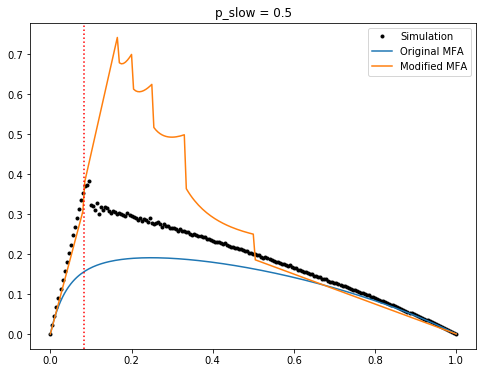

In [18]:
max_speed = 5
for p, (t, flow, flow2) in results.items():
    plt.figure(figsize=(8, 6))
    plt.title(f'p_slow = {p}')
    plt.plot(t, flow2 , 'k.', label='Simulation')
    plt.plot(t, compute_mfa(mfa_original, t, max_speed=5, p_slow=p), '-', label='Original MFA')
    plt.plot(t, compute_mfa(mfa_new, t, max_speed=5, p_slow=p), '-', label='Modified MFA')
    plt.axvline((1 - p)/(max_speed + 1), linestyle=':', color='r')
    plt.legend()
    plt.show()